In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchmetrics
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
!pip install kaggle --quiet
!pip install torchvision transformers --quiet

# Dataset

In [5]:
import kagglehub

path_data = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path_data)

Path to dataset files: /kaggle/input/eye-diseases-classification


In [6]:
!pip install split-folders

In [7]:
import splitfolders

splitfolders.ratio(
    input=f"{path_data}/dataset",
    output="eye_dataset",
    seed=1337,
    ratio=(.7, .2, .1)  # 70% train, 20% val, 10% test
)


Copying files: 4217 files [00:33, 126.47 files/s]


In [8]:
from torchvision.datasets import ImageFolder

class MappedImageFolder(ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):

        self.name_to_label = {
            'cataract': 0,
            'diabetic_retinopathy': 1,
            'glaucoma': 2,
            'normal': 3
        }
        self.label_to_name = {v: k for k, v in self.name_to_label.items()}
        super().__init__(root, transform=transform, target_transform=self.map_target)

    def map_target(self, original_class_idx):
        class_name = self.classes[original_class_idx]
        return self.name_to_label[class_name]

    def get_class_names(self):
        return list(self.name_to_label.keys())


# Hugging face model

In [9]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import requests
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image
from skimage.segmentation import mark_boundaries
import numpy as np

In [10]:
from transformers import AutoModelForImageClassification
import torch.nn as nn

In [11]:
import torch.nn.functional as F
from torch import optim

In [12]:
from torchvision.datasets import ImageFolder

In [13]:
processor = AutoImageProcessor.from_pretrained("NeuronZero/EyeDiseaseClassifier")
model = AutoModelForImageClassification.from_pretrained("NeuronZero/EyeDiseaseClassifier")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/781 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: '_valid_processor_keys'
  return func(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [14]:
print(model.config.id2label)

{0: 'AMD', 1: 'Cataract', 2: 'Diabetes', 3: 'Glaucoma', 4: 'Hypertension', 5: 'Myopia', 6: 'Normal', 7: 'Other'}


In [15]:
class HFProcessorWrapper:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, image):
        return self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)


In [16]:
transform = HFProcessorWrapper(processor)

# Cargar dataset

In [17]:
train_dataset = MappedImageFolder("eye_dataset/train", transform=transform)
val_dataset = MappedImageFolder("eye_dataset/val", transform=transform)
test_dataset = MappedImageFolder("eye_dataset/test", transform=transform)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [19]:
print("Clases detectadas:", train_dataset.get_class_names())

Clases detectadas: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


# Model

In [20]:
model.classifier = nn.Linear(model.classifier.in_features, 4)

In [21]:
model.config.id2label = {
    0: "Cataract",
    1: "DiabeticRetinopathy",
    2: "Glaucoma",
    3: "Normal"
}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Entrenamiento

In [23]:
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [24]:
def train_one_epoch(model, dataloader):
    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=images)
        loss = F.cross_entropy(outputs.logits, labels)

        total_loss += loss.item()
        total_correct += (outputs.logits.argmax(1) == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

def evaluate(model, dataloader):
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(pixel_values=images)
            preds = outputs.logits.argmax(1)
            total_correct += (preds == labels).sum().item()
    return total_correct / len(dataloader.dataset)


In [25]:
n_epoch = 50

In [26]:
train_losses = []
train_accuracies = []
val_accuracies = []

In [27]:
for epoch in range(n_epoch):
    loss, acc = train_one_epoch(model, train_loader)
    val_acc = evaluate(model, val_loader)

    train_losses.append(loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {loss:.4f} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1 | Train Loss: 0.4565 | Train Acc: 0.8152 | Val Acc: 0.9025
Epoch 2 | Train Loss: 0.1969 | Train Acc: 0.9285 | Val Acc: 0.9239
Epoch 3 | Train Loss: 0.1372 | Train Acc: 0.9502 | Val Acc: 0.9144
Epoch 4 | Train Loss: 0.0846 | Train Acc: 0.9688 | Val Acc: 0.9108
Epoch 5 | Train Loss: 0.1004 | Train Acc: 0.9668 | Val Acc: 0.8621
Epoch 6 | Train Loss: 0.0956 | Train Acc: 0.9681 | Val Acc: 0.9084
Epoch 7 | Train Loss: 0.0419 | Train Acc: 0.9861 | Val Acc: 0.8977
Epoch 8 | Train Loss: 0.0698 | Train Acc: 0.9759 | Val Acc: 0.9108
Epoch 9 | Train Loss: 0.0428 | Train Acc: 0.9844 | Val Acc: 0.9203
Epoch 10 | Train Loss: 0.0061 | Train Acc: 0.9990 | Val Acc: 0.9310
Epoch 11 | Train Loss: 0.0342 | Train Acc: 0.9878 | Val Acc: 0.9156
Epoch 12 | Train Loss: 0.0719 | Train Acc: 0.9766 | Val Acc: 0.9203
Epoch 13 | Train Loss: 0.0311 | Train Acc: 0.9891 | Val Acc: 0.9120
Epoch 14 | Train Loss: 0.0172 | Train Acc: 0.9939 | Val Acc: 0.9180
Epoch 15 | Train Loss: 0.0255 | Train Acc: 0.9915 | Val A

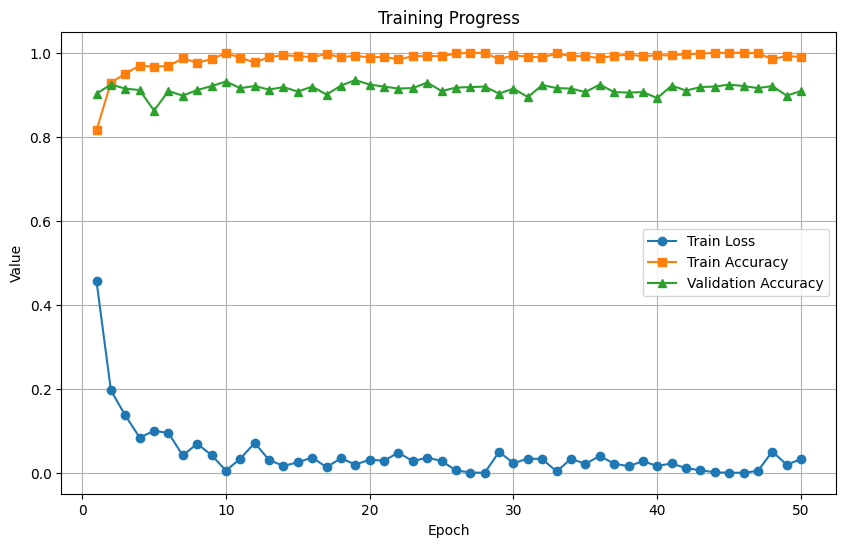

In [28]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="s")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="^")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
model_path = "fine_tuned_eye_model"
model.save_pretrained(model_path)
processor.save_pretrained(model_path)

['fine_tuned_eye_model/preprocessor_config.json']

In [30]:
!cp -r fine_tuned_eye_model /content/drive/MyDrive/

In [31]:
import pandas as pd

test_data = [{"path": path, "label": label} for (path, label) in zip(test_dataset.samples, test_dataset.targets)]
df_test = pd.DataFrame(test_data)

df_test.to_csv("test_data.csv", index=False)

!cp -r eye_dataset/test /content/drive/MyDrive/eye_test_images/
!cp test_data.csv /content/drive/MyDrive/

In [32]:
metrics_df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": train_losses,
    "train_acc": train_accuracies,
    "val_acc": val_accuracies
})

metrics_df.to_csv("/content/drive/MyDrive/training_metrics.csv", index=False)
